In [230]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap

import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

X_train = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/X_train_leisure.parquet")
X_test = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/X_test_leisure.parquet")
y_train = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/y_train_leisure.parquet")
y_test = pd.read_parquet(f"{PATH_PROJECT}data/counting_trips/y_test_leisure.parquet")

In [2]:
shap.initjs()

In [90]:
def valid_model(y_train, y_test, y_pred_train, y_pred_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print("----Train---")
    print(f"MAE: {mae_train:.2f}")
    print(f"MSE: {mse_train:.2f}")
    print(f"R2: {r2_train:.2f}")
    print("---- Test ---")
    print(f"MAE: {mae_test:.2f}")
    print(f"MSE: {mse_test:.2f}")
    print(f"R2: {r2_test:.2f}")
    return None

def lr_modeling(X_train, X_test, y_train, y_test):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return reg

def rf_modeling(X_train, X_test, y_train, y_test, params):
    reg = RandomForestRegressor(**params)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    feats = {}
    for feature, importance in zip(X_train.columns, reg.feature_importances_):
        feats[feature] = importance * 100
    df_imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values("Importance", ascending=False)
    print("Main Features:")
    print(df_imp.head(10))
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return reg

def xgb_modeling(X_train, X_test, y_train, y_test, params):
    model_xgb = xgboost.XGBRegressor(**params)
    model_xgb.fit(X_train, y_train)
    y_pred_train = model_xgb.predict(X_train)
    y_pred_test = model_xgb.predict(X_test)
    valid_model(y_train, y_test, y_pred_train, y_pred_test)
    return model_xgb


In [150]:
lr_modeling(X_train, X_test, y_train, y_test)

----Train---
MAE: 0.24
MSE: 0.15
R2: 0.18
---- Test ---
MAE: 0.24
MSE: 0.15
R2: 0.17


LinearRegression()

In [9]:
rf_params = {"n_estimators": 50, "max_depth": 12, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": -1}
reg = rf_modeling(X_train, X_test, y_train, y_test, rf_params)

Main Features:
                                               Importance
loc_domicilio_count_ilum_std                    41.428412
per Renda familiar mensal                       17.902353
Condição de atividade_Aposentado/ Pensionista    8.500603
loc_domicilio_count_parada                       6.394327
Idade                                            4.223175
loc_domicilio_dist_ciclo                         3.062333
loc_domicilio_dist_metro                         2.761633
loc_domicilio_ACC_TI_A_E_60M                     2.646411
loc_domicilio_dist_term                          2.477495
loc_domicilio_dist_trem                          2.467310
----Train---
MAE: 0.19
MSE: 0.11
R2: 0.36
---- Test ---
MAE: 0.20
MSE: 0.13
R2: 0.28


In [119]:
params_xgb = {"max_depth": 3, "subsample": 0.8, "learning_rate": 0.1, "n_estimators": 1000,  "scale_pos_weight": 1, "seed": 42}
reg_xgb = xgb_modeling(X_train, X_test, y_train["Total Motivo Interesse"].values, y_test["Total Motivo Interesse"].values, params_xgb)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


----Train---
MAE: 0.18
MSE: 0.09
R2: 0.48
---- Test ---
MAE: 0.21
MSE: 0.13
R2: 0.28


In [86]:
rf_params = {"n_estimators": 50, "max_depth": 12, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": 2}
reg = rf_modeling(X_train, X_test, y_train["Total Motivo Interesse"].values, y_test["Total Motivo Interesse"].values, rf_params)

Main Features:
                                               Importance
loc_domicilio_count_ilum_std                    41.428412
per Renda familiar mensal                       17.902353
Condição de atividade_Aposentado/ Pensionista    8.500603
loc_domicilio_count_parada                       6.394327
Idade                                            4.223175
loc_domicilio_dist_ciclo                         3.062333
loc_domicilio_dist_metro                         2.761633
loc_domicilio_ACC_TI_A_E_60M                     2.646411
loc_domicilio_dist_term                          2.477495
loc_domicilio_dist_trem                          2.467310
----Train---
MAE: 0.19
MSE: 0.11
R2: 0.36
---- Test ---
MAE: 0.20
MSE: 0.13
R2: 0.28


In [267]:
sample = X_test.sample(1000)
explainer = shap.TreeExplainer(reg)
shap_values = explainer(sample)

In [120]:
explainer = shap.Explainer(reg_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


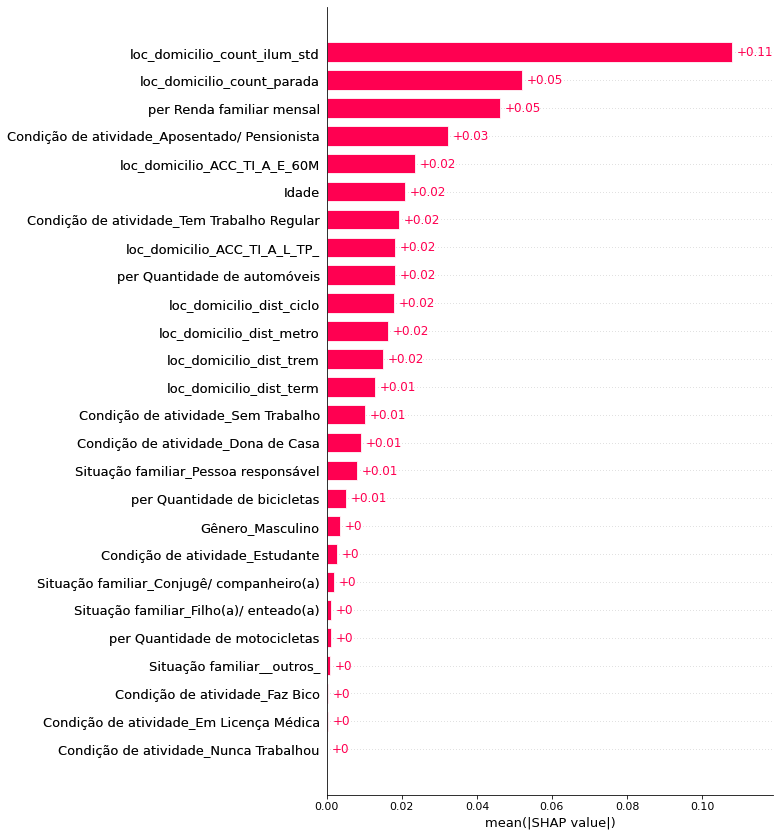

In [161]:
shap.plots.bar(shap_values, max_display=None)

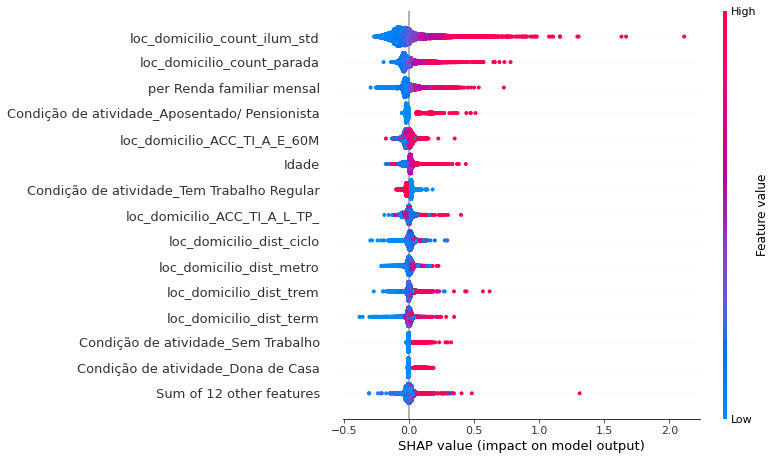

In [121]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=15)

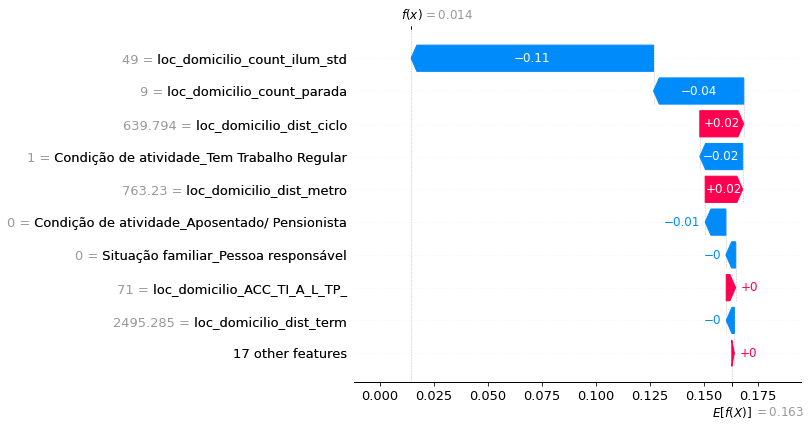

In [122]:
shap.waterfall_plot(shap_values[0])

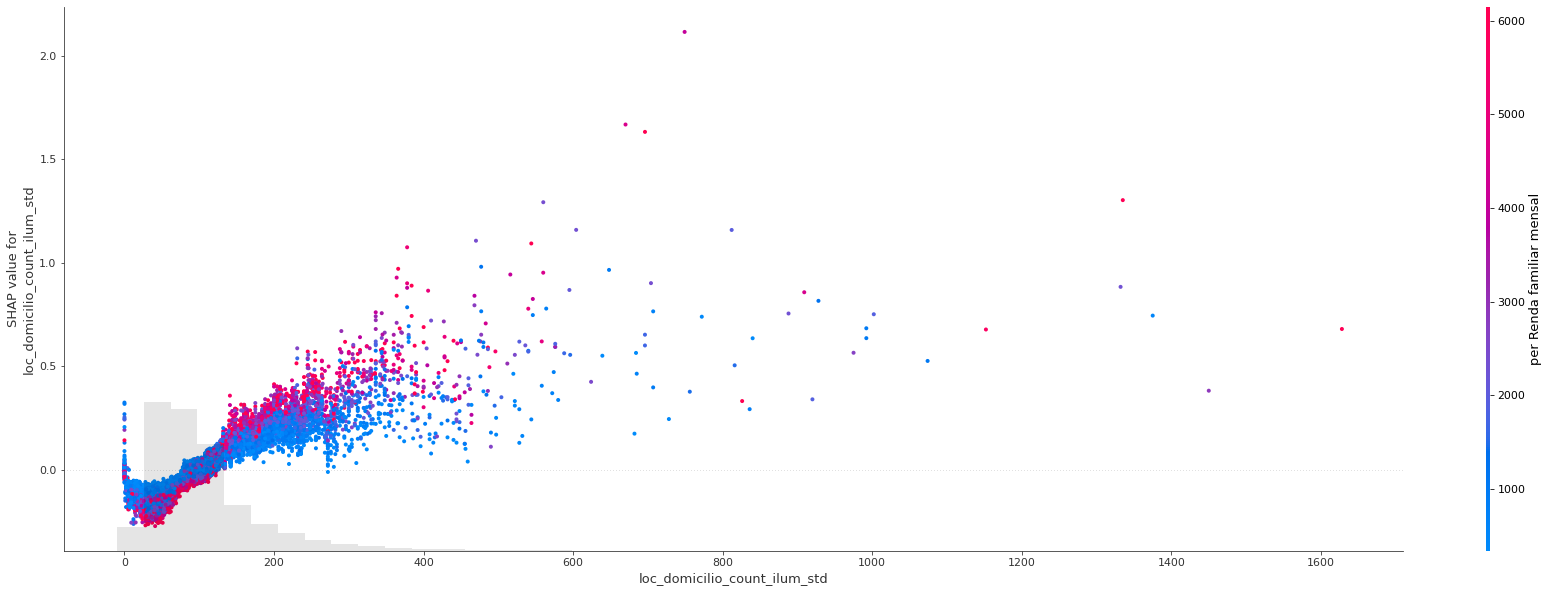

In [134]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_count_ilum_std"], shap_values[:,"per Renda familiar mensal"], ax=ax)

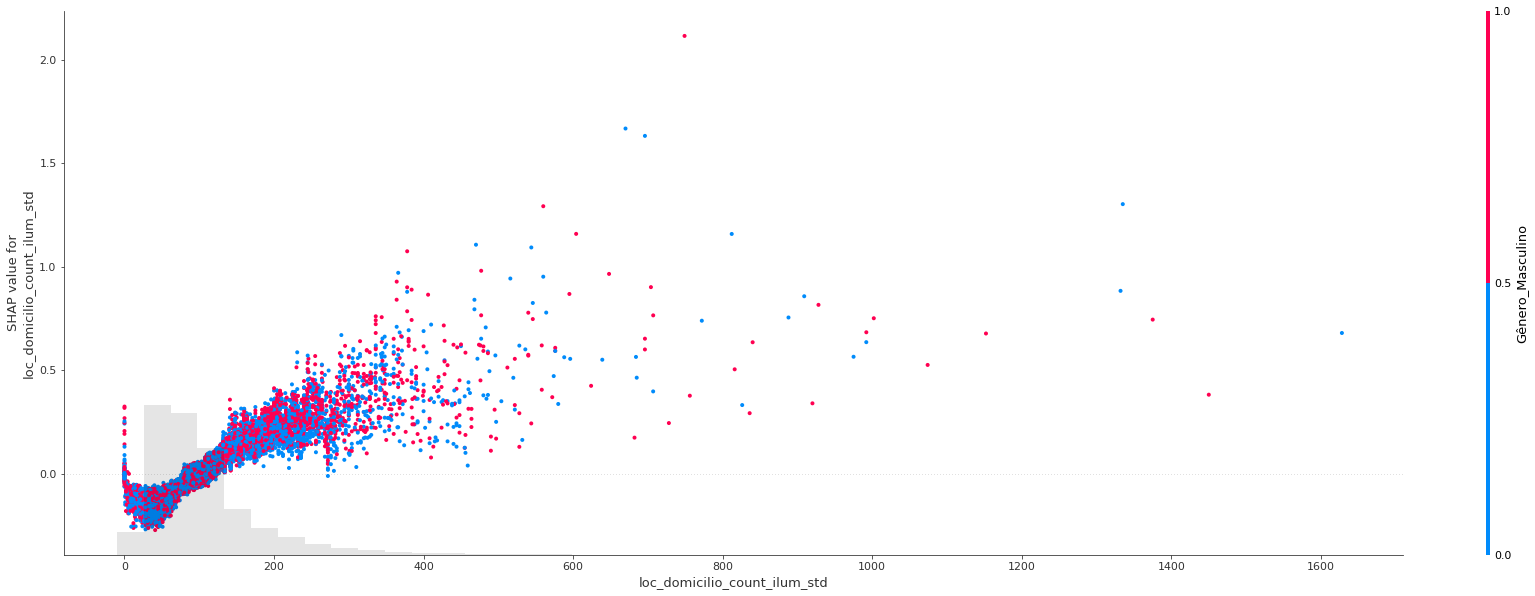

In [138]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_count_ilum_std"], shap_values[:,"Gênero_Masculino"], ax=ax)

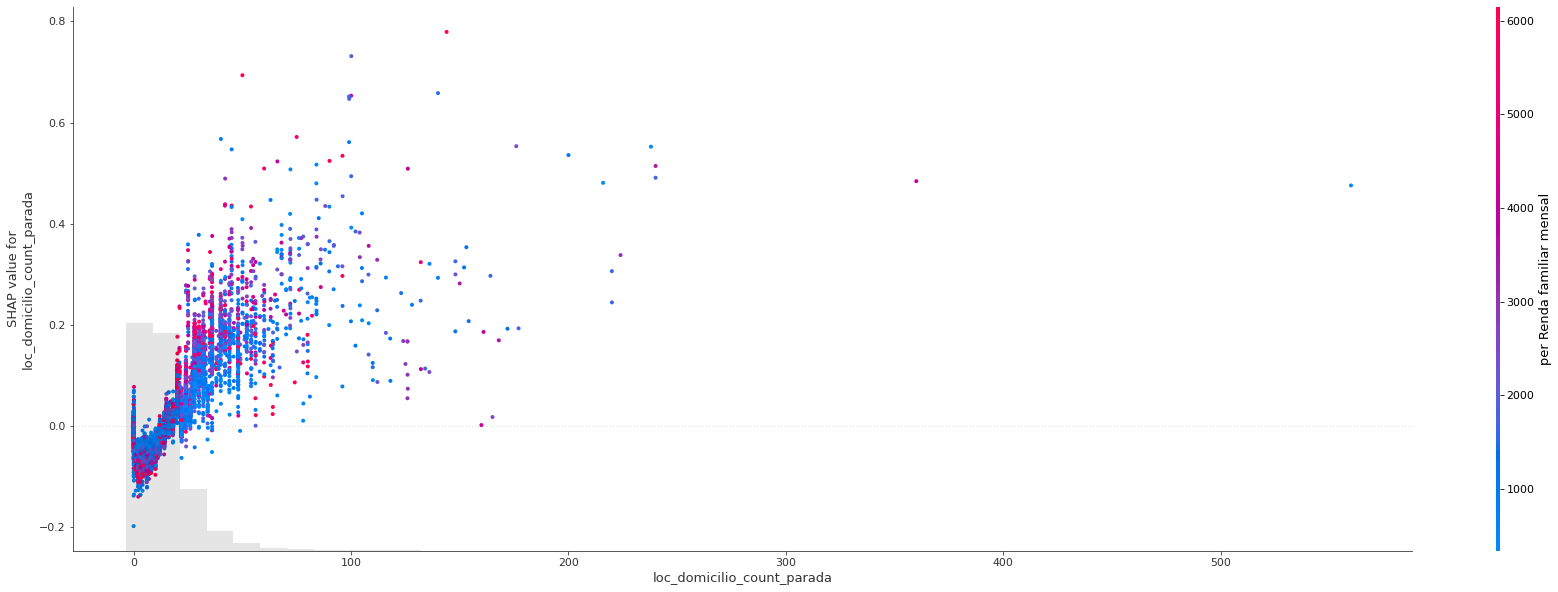

In [136]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_count_parada"], shap_values[:,"per Renda familiar mensal"], ax=ax)

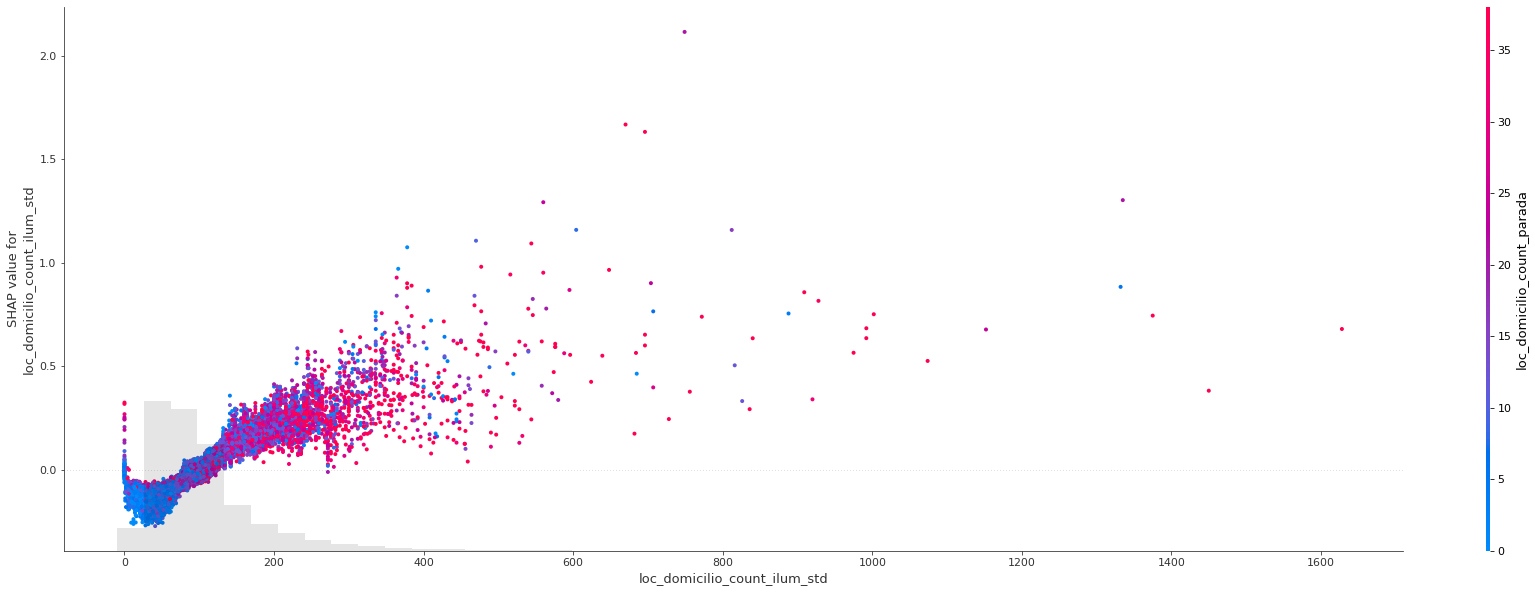

In [139]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_count_ilum_std"], shap_values[:,"loc_domicilio_count_parada"], ax=ax)

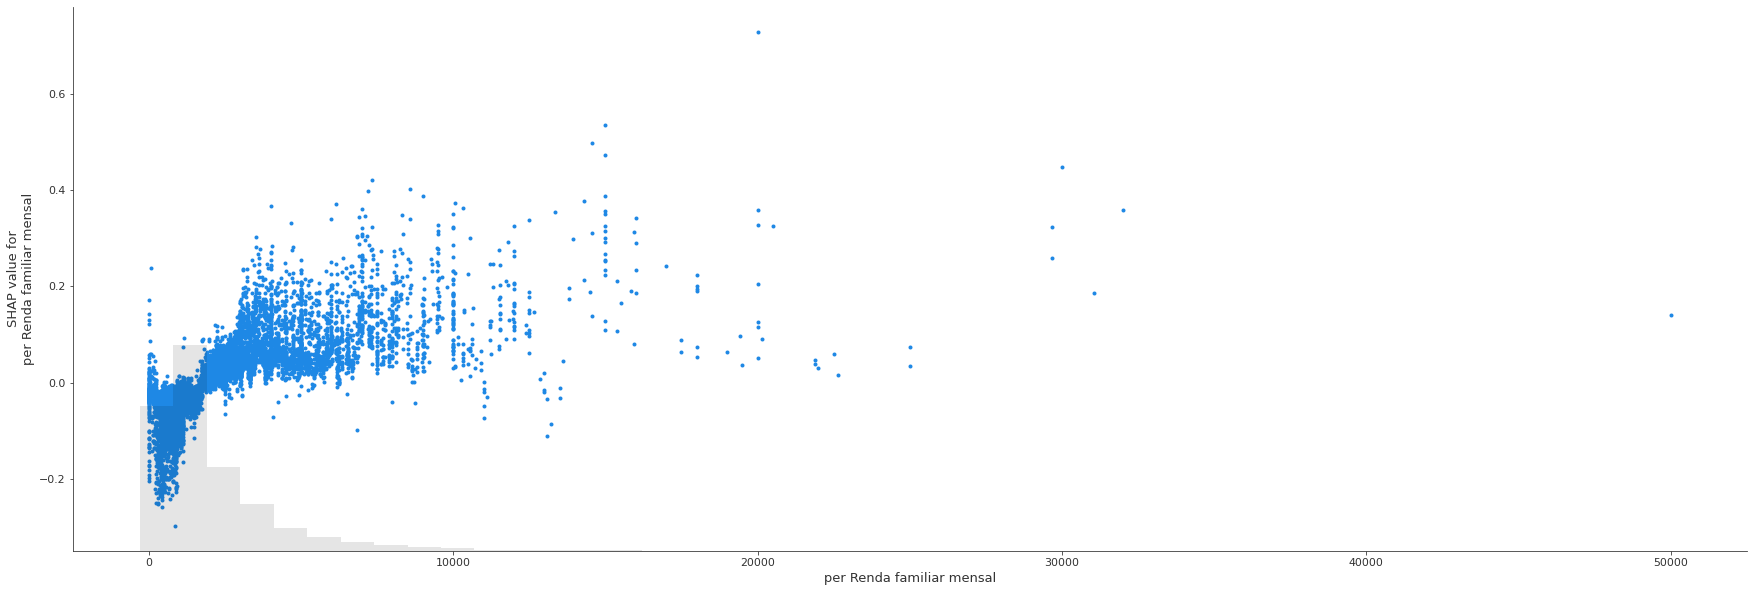

In [141]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"per Renda familiar mensal"], ax=ax)

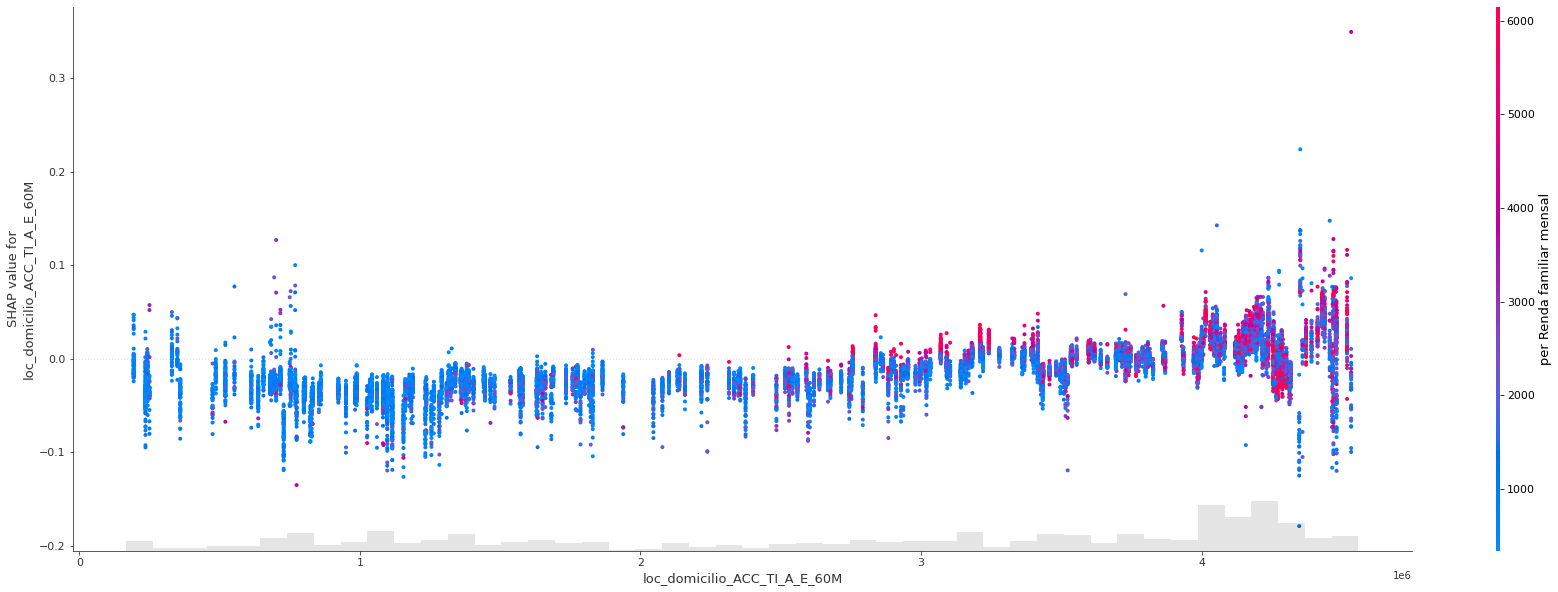

In [142]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_ACC_TI_A_E_60M"], color=shap_values[:,"per Renda familiar mensal"], ax=ax)

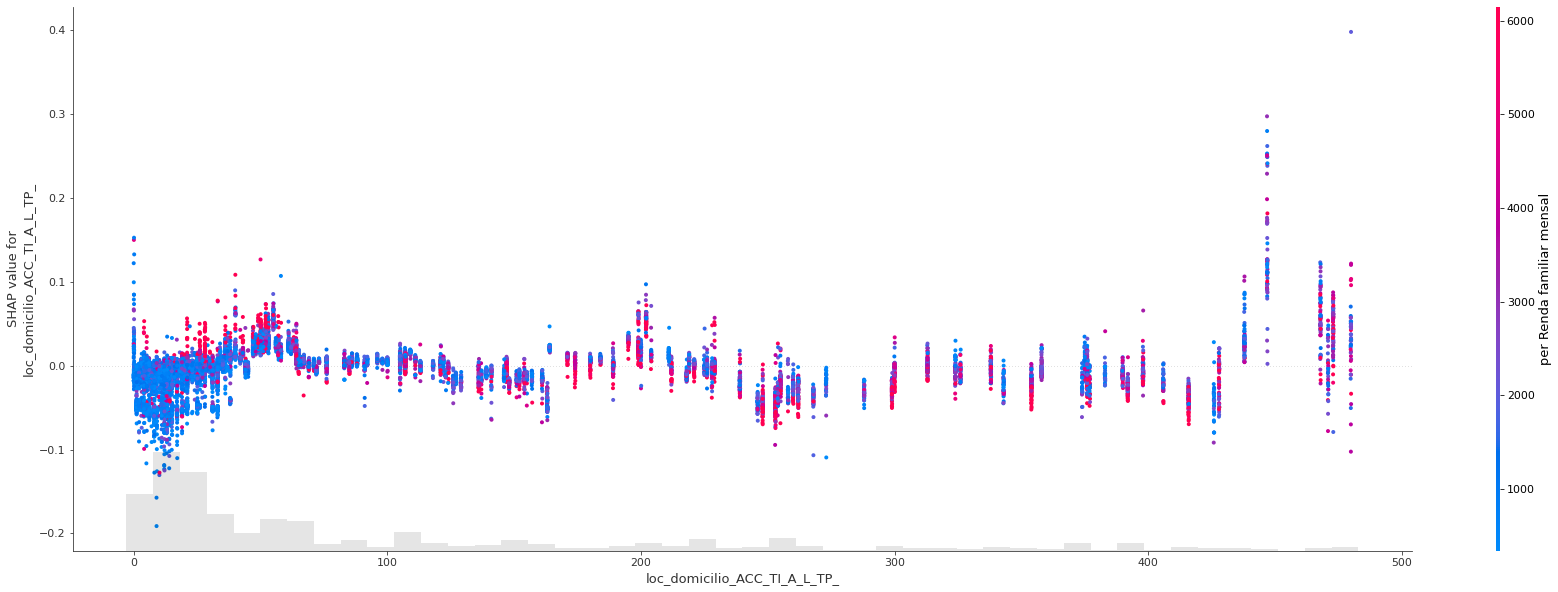

In [143]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_ACC_TI_A_L_TP_"], color=shap_values[:,"per Renda familiar mensal"], ax=ax)

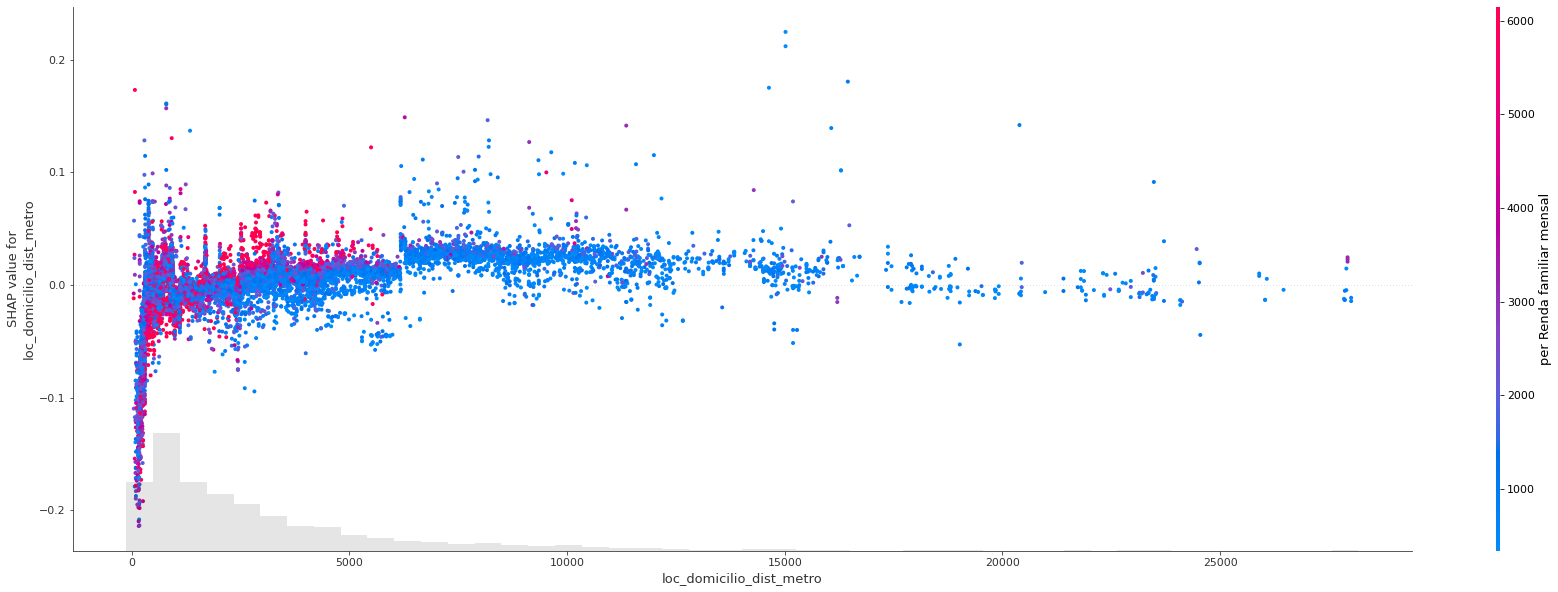

In [144]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"loc_domicilio_dist_metro"], color=shap_values[:,"per Renda familiar mensal"], ax=ax)

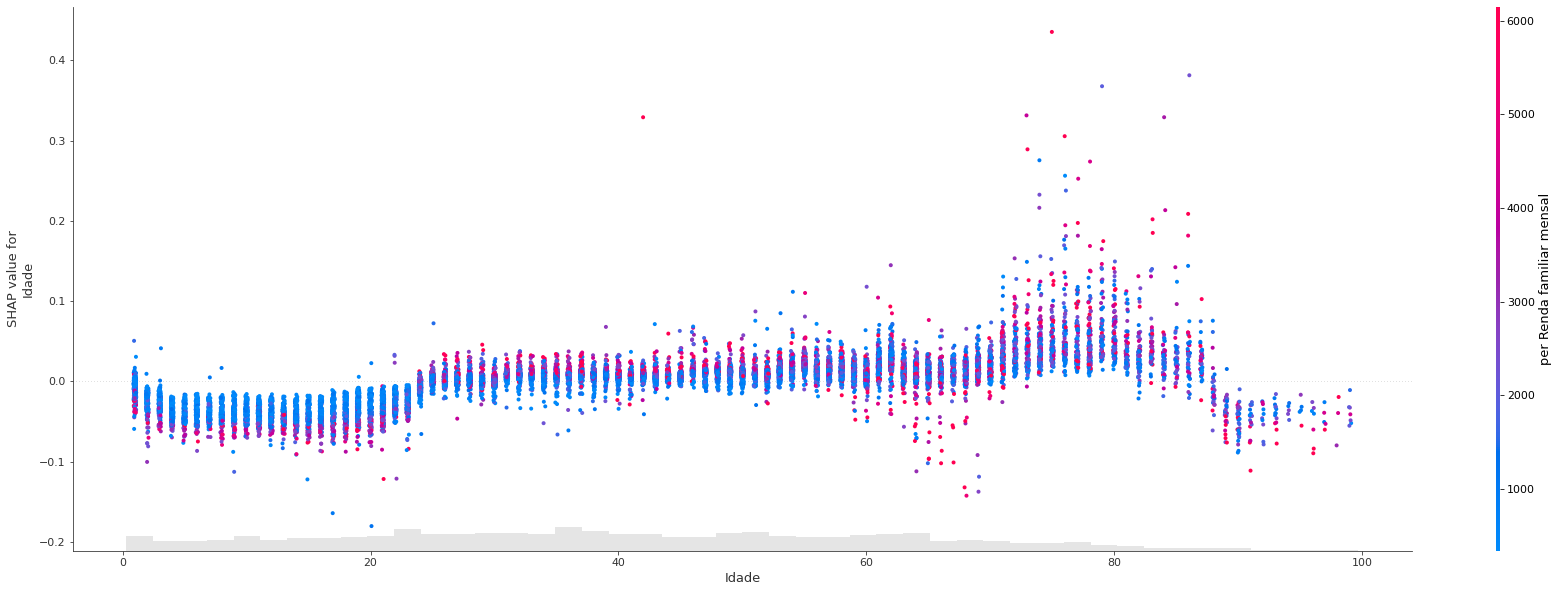

In [147]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"Idade"], color=shap_values[:,"per Renda familiar mensal"], ax=ax)

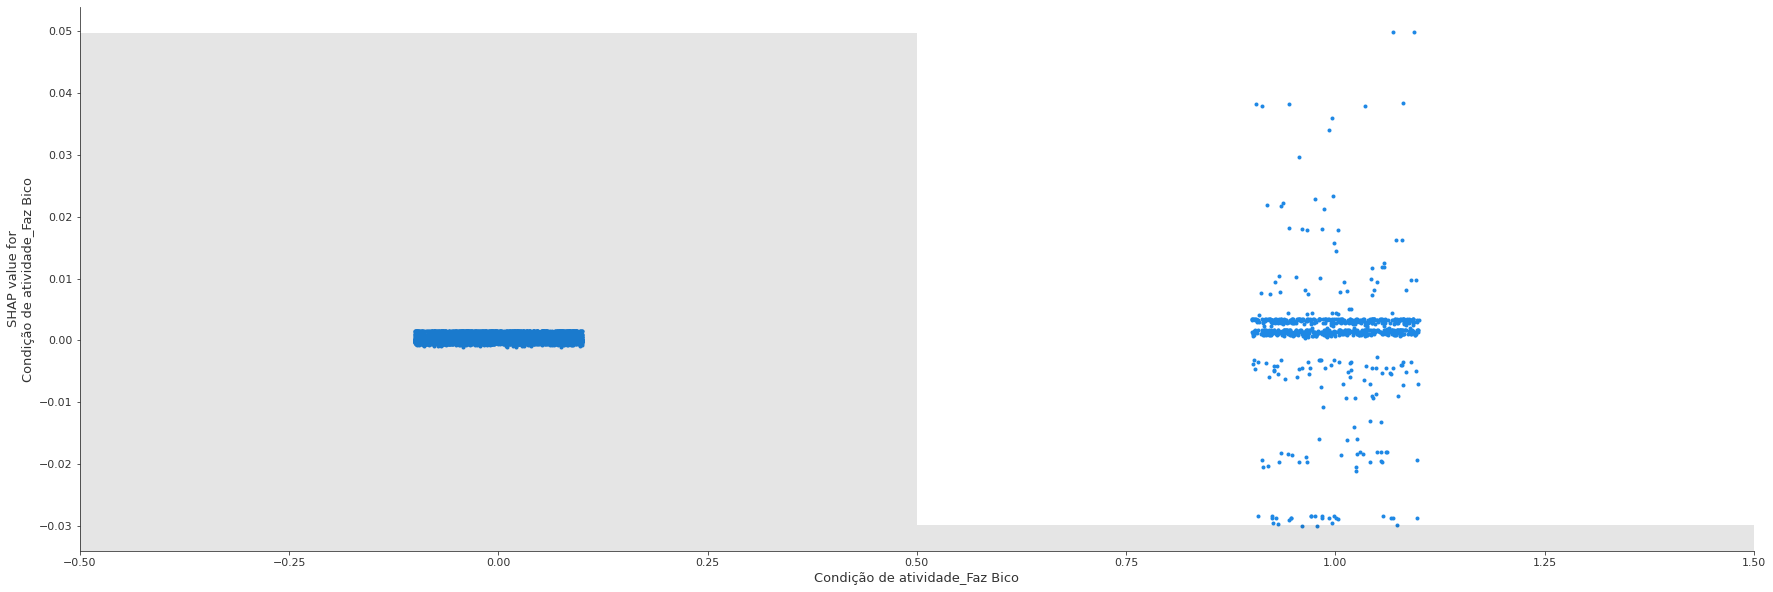

In [182]:
fig, ax = plt.subplots(1, figsize=(30,10))
shap.plots.scatter(shap_values[:,"Condição de atividade_Faz Bico"], ax=ax)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


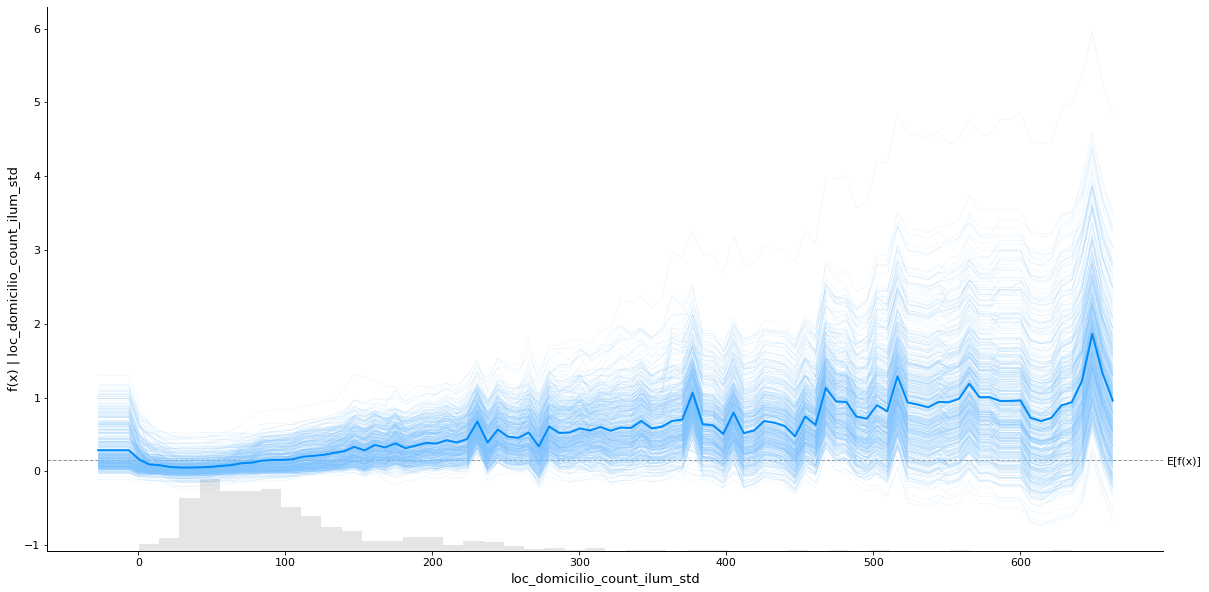

In [203]:
fig, ax = plt.subplots(1, figsize=(20,10))
shap.partial_dependence_plot("loc_domicilio_count_ilum_std", reg_xgb.predict, X_train.sample(500), ax=ax, model_expected_value=True)

In [284]:
6000 *.3

1800.0

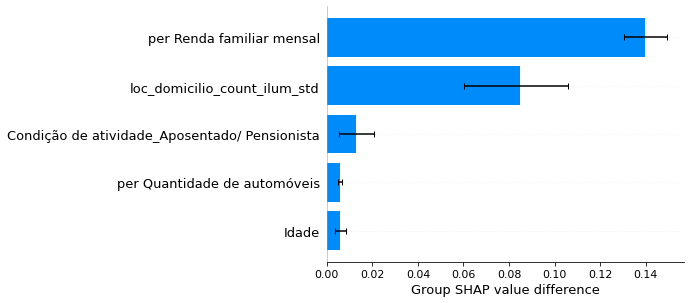

In [283]:
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -0.8
xmax = 0.8
sex_A = sample["per Renda familiar mensal"].values >= 3000
shap.group_difference_plot(shap_values.values, sex_A, sample.columns, max_display=5)

In [268]:
shap_values.data.shape

(1000, 26)

In [269]:
sample.shape

(1000, 26)

In [257]:
shap_values.sum(1)

.values =
array([-0.14856896, -0.0755605 , -0.20385812, ..., -0.13489889,
        0.19611908, -0.15389666], dtype=float32)

.data =
array([3796226.67745611, 3427476.19297406, 3504133.96908677, ...,
       3612550.75432889, 1319264.50698085, 3609202.48817645])

In [272]:
sample

,,,,,Idade,loc_domicilio_count_parada,loc_domicilio_count_ilum_std,loc_domicilio_dist_metro,loc_domicilio_dist_trem,loc_domicilio_dist_term,loc_domicilio_dist_ciclo,loc_domicilio_ACC_TI_A_E_60M,loc_domicilio_ACC_TI_A_L_TP_,per Quantidade de automóveis,...,Situação familiar__outros_,Gênero_Masculino,Condição de atividade_Aposentado/ Pensionista,Condição de atividade_Dona de Casa,Condição de atividade_Em Licença Médica,Condição de atividade_Estudante,Condição de atividade_Faz Bico,Condição de atividade_Nunca Trabalhou,Condição de atividade_Sem Trabalho,Condição de atividade_Tem Trabalho Regular
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,,,,,,,,,,,,,,,,,,,,,
03150462103,315.0,25042018,316514.0,7379702.0,9.0,8,36,4211.164471,8766.868919,2766.089526,6676.540225,1115434.0,12.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
02110014103,211.0,08082017,344130.0,7391205.0,6.0,10,124,1740.778735,5117.920836,2718.525990,341.419101,2952008.0,31.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
01810037101,181.0,15082017,348937.0,7400024.0,77.0,5,37,3780.877709,2033.311629,1629.304412,1975.968355,1362243.0,12.0,0.500000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02500516102,250.0,19052018,334385.0,7388255.0,68.0,7,45,1334.600296,3895.337095,2207.087708,1423.679028,3211671.0,42.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00500519103,50.0,23062018,334374.0,7391238.0,40.0,11,35,1432.881860,2741.945950,3197.176661,352.228162,3982442.0,118.0,0.333333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03200005102,320.0,09082017,323831.0,7387639.0,30.0,2,78,2928.603219,2273.699430,3539.057930,553.408428,3433596.0,50.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
02400540102,240.0,19052018,335437.0,7392093.0,74.0,18,51,2590.272880,1790.033891,3060.980376,865.508350,3603730.0,86.0,1.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02160765101,216.0,25042018,346382.0,7396082.0,82.0,10,112,927.056654,3511.350056,2804.993824,751.780051,2355520.0,20.0,1.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KeyboardInterrupt: 

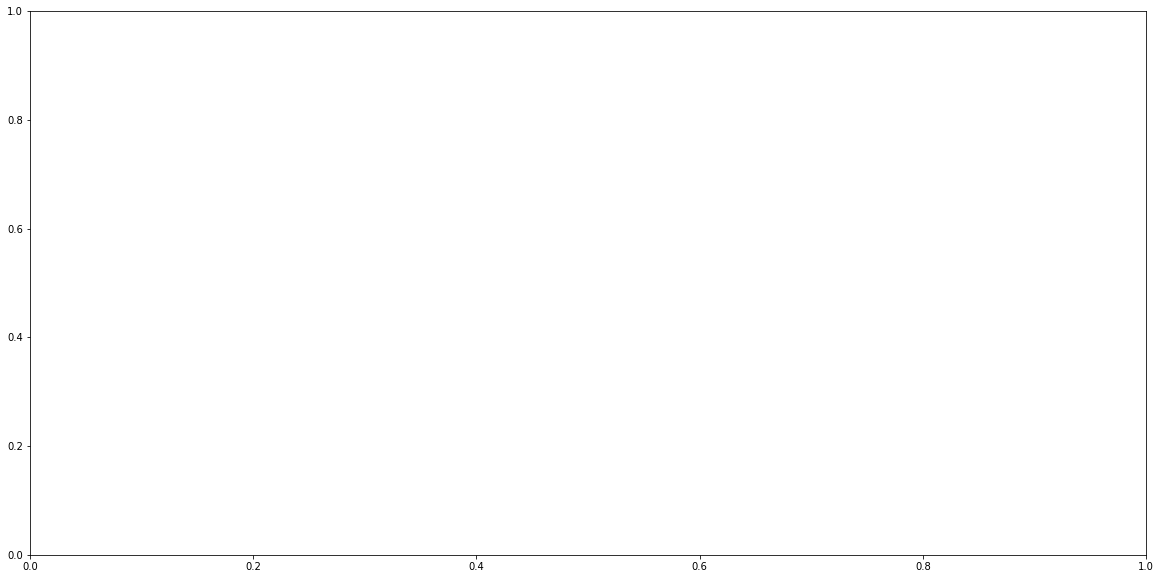

In [251]:
fig, ax = plt.subplots(1, figsize=(20,10))
shap.plots.heatmap(shap_values.sample(5000), max_display=6)

In [ ]:
shap_values.feature_names

In [227]:
df_shap = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

In [233]:
df_shap.head(5)

,Idade,loc_domicilio_count_parada,loc_domicilio_count_ilum_std,loc_domicilio_dist_metro,loc_domicilio_dist_trem,loc_domicilio_dist_term,loc_domicilio_dist_ciclo,loc_domicilio_ACC_TI_A_E_60M,loc_domicilio_ACC_TI_A_L_TP_,per Quantidade de automóveis,...,Situação familiar__outros_,Gênero_Masculino,Condição de atividade_Aposentado/ Pensionista,Condição de atividade_Dona de Casa,Condição de atividade_Em Licença Médica,Condição de atividade_Estudante,Condição de atividade_Faz Bico,Condição de atividade_Nunca Trabalhou,Condição de atividade_Sem Trabalho,Condição de atividade_Tem Trabalho Regular
0,0.001770,-0.041782,-0.112303,0.017373,0.002738,-0.003765,0.020338,0.001315,0.004378,-0.000979,...,0.000212,0.001623,-0.009596,-0.003730,-0.000112,0.001379,0.000060,-0.000004,-0.003681,-0.019855
1,0.014022,-0.049580,-0.074005,0.023908,0.012263,-0.008260,0.019605,0.004192,0.015379,0.015867,...,-0.000052,0.002380,-0.013440,-0.003537,-0.000110,0.000337,0.000060,-0.000004,-0.004382,-0.024895
2,0.013223,-0.063557,-0.147588,0.004945,-0.003849,-0.010569,0.004395,-0.008892,0.000139,-0.011708,...,0.000444,-0.001041,0.065366,-0.002909,-0.000130,0.001439,-0.000019,-0.000004,-0.003764,0.017973
3,0.014044,0.058491,0.184063,0.019161,0.018522,-0.001714,0.014396,-0.010743,0.016097,-0.009276,...,-0.000326,-0.007020,-0.023480,-0.007080,-0.000137,0.003193,0.000322,-0.000002,-0.005972,-0.017578
4,0.006922,-0.038155,-0.042621,0.003854,0.008646,-0.005975,0.002115,-0.021618,-0.005863,0.008973,...,0.000218,0.001681,-0.018565,-0.007098,-0.000134,0.000300,0.000067,-0.000003,-0.006214,-0.025538


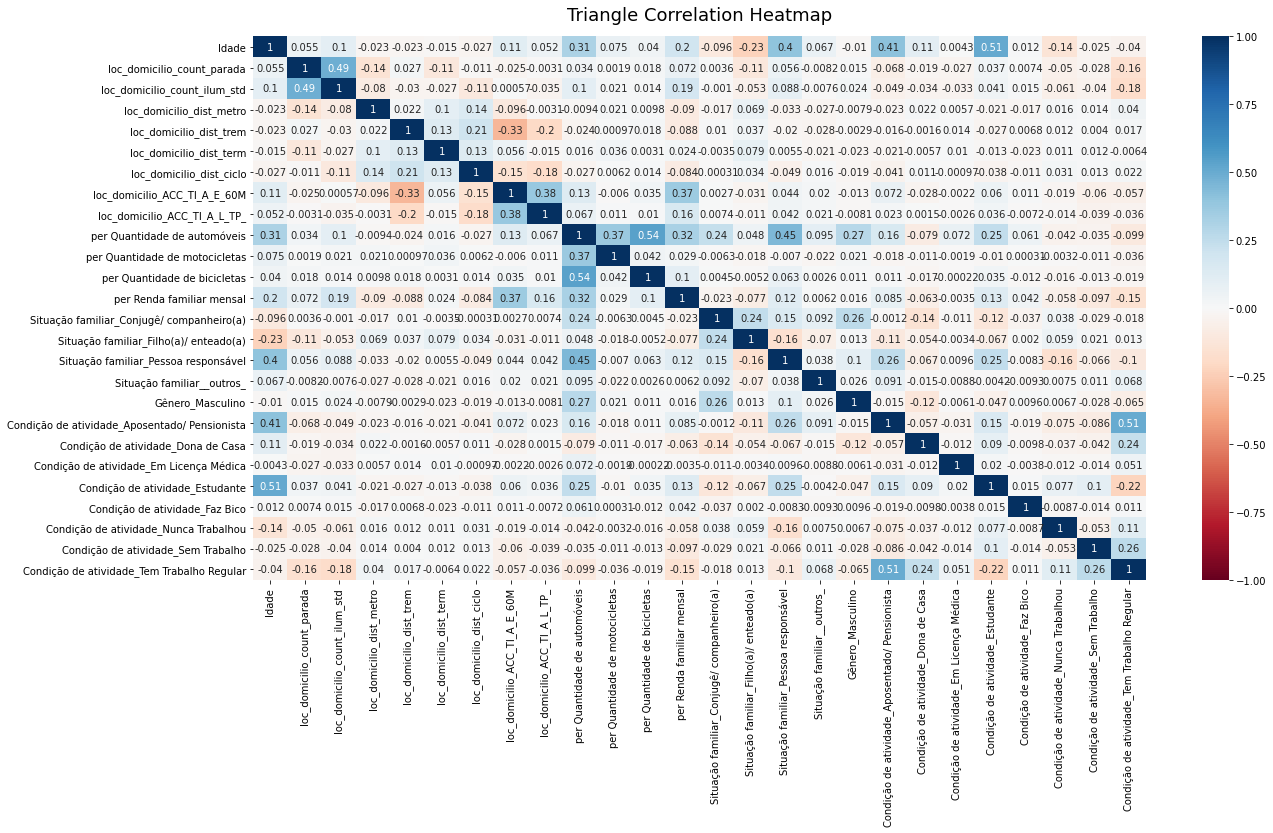

In [238]:
fig, ax = plt.subplots(1, figsize=(20,10))
# define the mask to set the values in the upper triangle to True
# mask = np.triu(np.ones_like(X_train.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_shap.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

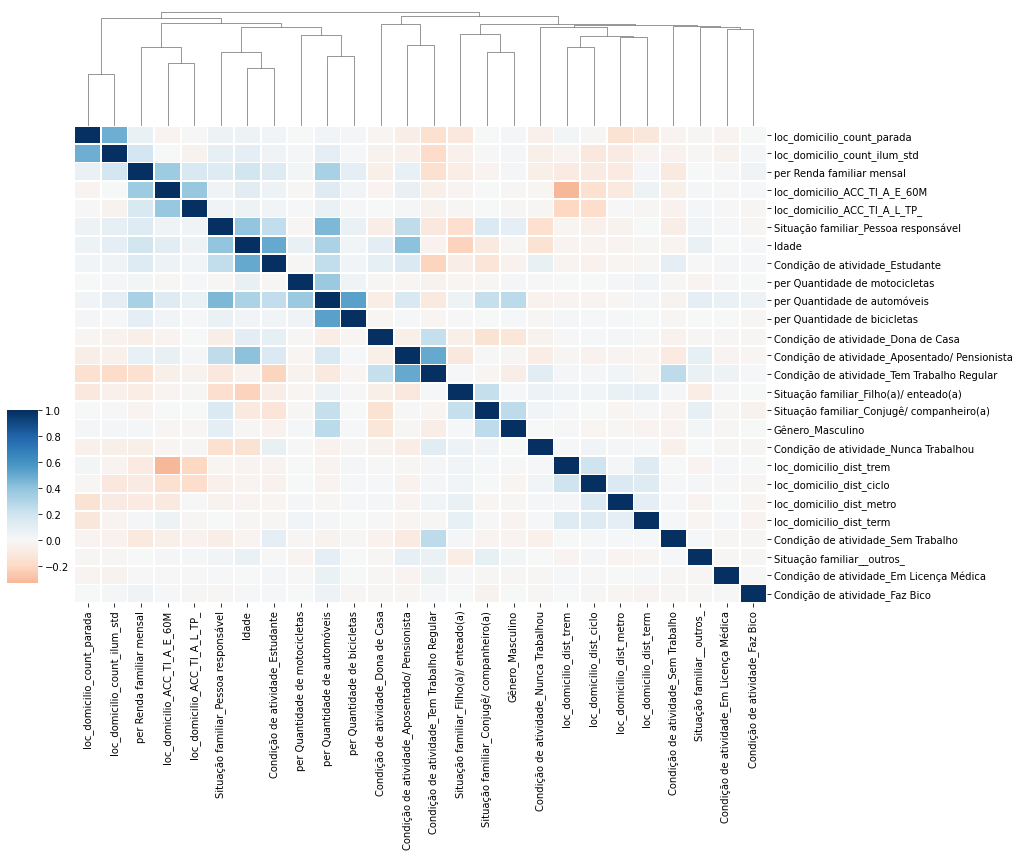

In [244]:
f = 0.8
# Draw the full plot
g = sns.clustermap(df_shap.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))

g.ax_row_dendrogram.remove()

In [107]:
shap_values.feature_names

['Idade',
 'loc_domicilio_count_parada',
 'loc_domicilio_count_ilum_std',
 'loc_domicilio_dist_metro',
 'loc_domicilio_dist_trem',
 'loc_domicilio_dist_term',
 'loc_domicilio_dist_ciclo',
 'loc_domicilio_ACC_TI_A_E_60M',
 'loc_domicilio_ACC_TI_A_L_TP_',
 'per Quantidade de automóveis',
 'per Quantidade de motocicletas',
 'per Quantidade de bicicletas',
 'per Renda familiar mensal',
 'Situação familiar_Conjugê/ companheiro(a)',
 'Situação familiar_Filho(a)/ enteado(a)',
 'Situação familiar_Pessoa responsável',
 'Situação familiar__outros_',
 'Gênero_Masculino',
 'Condição de atividade_Aposentado/ Pensionista',
 'Condição de atividade_Dona de Casa',
 'Condição de atividade_Em Licença Médica',
 'Condição de atividade_Estudante',
 'Condição de atividade_Faz Bico',
 'Condição de atividade_Nunca Trabalhou',
 'Condição de atividade_Sem Trabalho',
 'Condição de atividade_Tem Trabalho Regular']

In [179]:
def t_stat_shap_values(shap_value, col):
    shap_data = pd.DataFrame({"shap_value":shap_value[:,col].values, "value":shap_value[:,col].data})
    v_1 = shap_data[shap_data["value"] == 1].shap_value.values
    v_0 = shap_data[shap_data["value"] == 0].shap_value.values
    print(f"v_1: {v_1.mean()}")
    print(f"v_0: {v_0.mean()}")
    print(f"p-values: {stats.ttest_ind(v_1,v_0, equal_var=False).pvalue}")
    
t_stat_shap_values(shap_values, "Gênero_Masculino")

v_1: 0.003560395445674658
v_0: -0.003344001481309533
p-values: 0.0


In [180]:
shap_values.feature_names

['Idade',
 'loc_domicilio_count_parada',
 'loc_domicilio_count_ilum_std',
 'loc_domicilio_dist_metro',
 'loc_domicilio_dist_trem',
 'loc_domicilio_dist_term',
 'loc_domicilio_dist_ciclo',
 'loc_domicilio_ACC_TI_A_E_60M',
 'loc_domicilio_ACC_TI_A_L_TP_',
 'per Quantidade de automóveis',
 'per Quantidade de motocicletas',
 'per Quantidade de bicicletas',
 'per Renda familiar mensal',
 'Situação familiar_Conjugê/ companheiro(a)',
 'Situação familiar_Filho(a)/ enteado(a)',
 'Situação familiar_Pessoa responsável',
 'Situação familiar__outros_',
 'Gênero_Masculino',
 'Condição de atividade_Aposentado/ Pensionista',
 'Condição de atividade_Dona de Casa',
 'Condição de atividade_Em Licença Médica',
 'Condição de atividade_Estudante',
 'Condição de atividade_Faz Bico',
 'Condição de atividade_Nunca Trabalhou',
 'Condição de atividade_Sem Trabalho',
 'Condição de atividade_Tem Trabalho Regular']

In [181]:
t_stat_shap_values(shap_values.sample(100), "Condição de atividade_Faz Bico")

v_1: 0.0017115387599915266
v_0: 7.195786747615784e-05
p-values: 0.004854643163042125


In [154]:
from scipy import stats

shap_data = pd.DataFrame({"shap_value":shap_values[:,"Gênero_Masculino"].values, "value":shap_values[:,"Gênero_Masculino"].data})
v_male = shap_data[shap_data["value"] == 1].shap_value.values
v_female = shap_data[shap_data["value"] == 0].shap_value.values

stats.ttest_ind(v_male,v_female).pvalue

0.0

In [46]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

In [47]:
y_test["idx"] = np.arange(y_test.shape[0])
y_test.sort_values(by=list(y_test.columns), ascending=False)[:20]

,,,,,Total Motivo Interesse,idx
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,,
00250035101,25.0,19082017,331586.0,7394021.0,5,2449
02200010103,220.0,07042018,350538.0,7394838.0,4,13302
00920355101,92.0,29032018,329848.0,7397575.0,4,10915
03270060101,327.0,01072018,322630.0,7387307.0,4,8891
03401003101,340.0,05062018,325603.0,7392933.0,4,8785
02680089101,268.0,22052018,328242.0,7386312.0,4,2642
00920331101,92.0,18112017,329831.0,7397603.0,3,15838
01340050101,134.0,24082017,333905.0,7401519.0,3,14987
01440006101,144.0,21112017,331609.0,7403283.0,3,14757


Total Motivo Interesse     0
idx                       42
Name: (02030419102, 203.0, 16032018, 354669.0, 7396730.0), dtype: int64


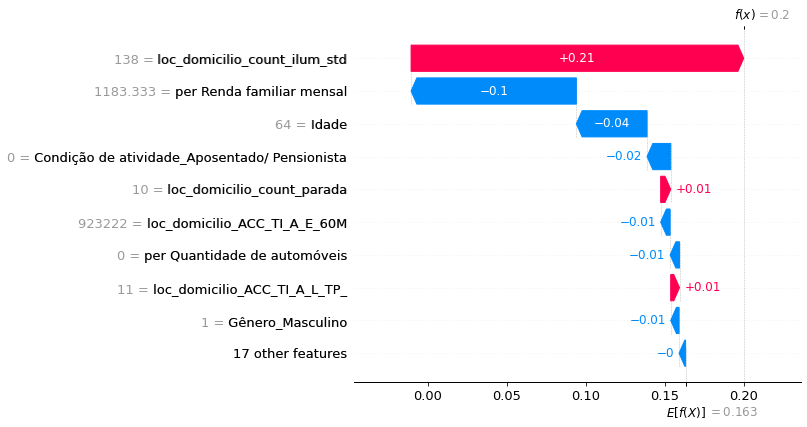

In [48]:
row = 42
shap_object = ShapObject(base_values = shap_values[row].base_values[0],
                         values = shap_values[row].values,
                         feature_names = X_test.columns,
                         data = X_test.iloc[row])
print(y_test.iloc[row])
shap.waterfall_plot(shap_object)

In [59]:
# train XGBoost model
import xgboost
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

In [69]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [78]:
model_xgb = xgboost.XGBRegressor().fit(X_train, y_train["Total Motivo Interesse"].values)

In [79]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_train.sample(500))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


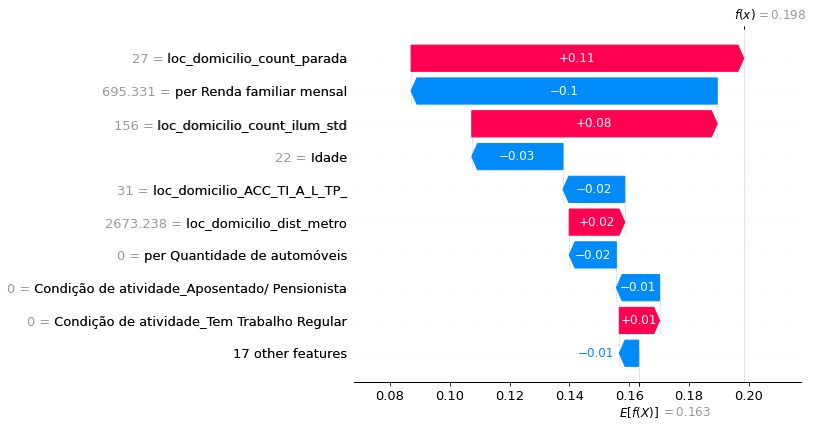

In [80]:
shap.plots.waterfall(shap_values[0])

In [89]:
shap.plots.scatter(shap_values[:,"loc_domicilio_count_ilum_std"])

IndexError: index 2 is out of bounds for axis 1 with size 1

In [32]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values, color=shap_object)

Exception: The passed Explanation object has multiple columns, please pass a single feature column to shap.plots.dependence like: shap_values[:,column]

In [248]:
shap_values[0]

.values =
array([ 1.7696399e-03, -4.1781515e-02, -1.1230295e-01,  1.7373223e-02,
        2.7383296e-03, -3.7652976e-03,  2.0337645e-02,  1.3154472e-03,
        4.3777851e-03, -9.7905390e-04, -4.1292387e-04,  2.0715578e-03,
        8.8982529e-04, -1.6236939e-03, -3.4806615e-04, -4.5273649e-03,
        2.1247061e-04,  1.6231956e-03, -9.5963739e-03, -3.7297616e-03,
       -1.1198395e-04,  1.3792875e-03,  6.0264305e-05, -3.5314340e-06,
       -3.6805137e-03, -1.9854585e-02], dtype=float32)

.base_values =
0.16289598

.data =
array([5.90000000e+01, 9.00000000e+00, 4.90000000e+01, 7.63230440e+02,
       7.92117779e+02, 2.49528476e+03, 6.39793985e+02, 3.78955200e+06,
       7.10000000e+01, 4.00000000e-01, 0.00000000e+00, 0.00000000e+00,
       1.79285050e+03, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00])

In [18]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"idade"], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices